In [1]:
import sys
sys.path.append('../../')

In [2]:
preprocessed_dataset_path = 'preprocessed_dataset/'

In [3]:
from codes.docs.analysis import data_preprocessing, data_exploration, visualisation, data_preprocessing_high_dimension
from codes.docs.analysis.gene_analysis import genetic_file_preprocess

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from collections import defaultdict
%matplotlib inline
import tqdm

import statsmodels.api as sm
import statsmodels.formula.api as sfm

from scipy.stats import ttest_ind, pearsonr,zscore
import pandas as pd
import re

Here, the volumetric dataset is preprocessed to group the same brain regions.\
Then mass univariate test is preformed, across multiple regions.

# Main analysis

In [87]:
european_volumetric_dataset_term = pd.read_csv(
    preprocessed_dataset_path +
    'imaging_data/volumetric/term/european_volumetric_df.csv')
# mixed_volumetric_dataset_term = pd.read_csv(
#     preprocessed_dataset_path +
#     'imaging_data/volumetric/term/mixed_volumetric_df.csv')

In [104]:
dependentVar = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('Imperial \d', i)) or bool(re.search('AAL \d',i))
]
df = european_volumetric_dataset_term.copy()
df = data_preprocessing.Volumes.Group_Imperial_volumes(df,grouping=None)
df = data_exploration.MassUnivariate.remove_outliers(df,
                                                    col=dependentVar,
                                                     threshold=3,
                                                    remove_schemes='percentage',
                                                    percentage_of_outlier=0.1)

In [86]:
df.shape

(205, 4520)

In [7]:
# plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams["axes.grid.axis"] ="y"
sns.set_style('whitegrid')
g = sns.FacetGrid(mixed_volumetric_dataset_term[['GA_vol','PMA_vol','cohort']],col='cohort',height = 4)
g.map(sns.histplot,'GA_vol',label='GA at birth',color='darkblue',alpha=0.15,shrink=.8)
g.map(sns.histplot,'PMA_vol',label='PMA at scan',color='darkblue',alpha=0.5,shrink=.8)
g.set_ylabels('Number of subjects',fontsize=15)
g.set_xlabels('[weeks]',fontsize=15,fontname='Helvetica')
g.axes[0][0].set_yticklabels(([int(i) for i in g.axes[0][0].get_yticks()]),size=15)
g.axes[0][0].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)
g.axes[0][1].set_xticklabels(([int(i) for i in g.axes[0][0].get_xticks()]),size=15)


g.axes[0][0].set_title('cohort = European',size=15)
g.axes[0][1].set_title('cohort = Asian',size=15)
plt.legend(ncol=2,loc='upper center',fontsize=15,frameon=False)
sns.despine(bottom=True,left=True)
# g.savefig(f'./{preprocessed_dataset_path}/output_plot/Cohort_age_distribution.pdf',transparent=True)

## AAL atlas

In [11]:
combined = df[[
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('AAL \d', i))
]].copy()
# combined = df[[i for i in df
#                .columns if 'PRS' in i]]
correlation_matrix = np.corrcoef(combined, rowvar=False)
data_exploration.matSpDLite(correlation_matrix, alpha=0.05)

Effective Number of Independent Variables [Veff] is 47.175858187992
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 28.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.0017857142857142872


In [105]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
# df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[i for i in european_volumetric_dataset_term.columns if bool(re.search('AAL \d',i))]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol','17 ICV (all except bone)']+ancestry,
    dependentVar_cols=dependentVar_cols)

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.53it/s]


In [14]:
0.05/7/28

0.00025510204081632655

In [13]:
european_volumetric_term_mass_univariate.sort_values(by='PRS_pval').head(22)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
112,AAL 20,0.002635,0.960764,-0.055965,0.260123,0.061474,0.399894,0.812604,4.373374e-29,0.005433,0.888206,-0.066348,0.082100,-0.008314,0.824302,0.152844,0.000083,-0.005568,0.945826,PRS_1e-07
715,AAL 65,0.057583,0.322873,0.068126,0.209111,0.056995,0.469508,0.747493,4.313192e-23,-0.012171,0.771312,-0.007646,0.853625,0.010234,0.800461,-0.141710,0.000639,-0.121696,0.172646,PRS_0.05
528,AAL 64,-0.006791,0.911739,0.029000,0.608267,0.091461,0.269153,0.707966,7.241515e-20,-0.062576,0.155035,-0.015404,0.723556,0.111337,0.009388,-0.141831,0.001307,0.014352,0.878776,PRS_0.001
69,AAL 70,0.022894,0.758212,-0.045512,0.511556,0.054777,0.590058,0.642028,1.736619e-12,-0.045460,0.396566,-0.090658,0.087098,-0.044030,0.397915,0.169482,0.001414,-0.048385,0.670517,PRS_1e-08
19,AAL 20,0.008623,0.873808,-0.071550,0.158359,0.059193,0.425428,0.816091,1.212725e-28,-0.001302,0.973454,-0.062016,0.108767,-0.005336,0.888302,0.121401,0.001730,-0.018225,0.826245,PRS_1e-08
986,AAL 57,-0.117657,0.013477,-0.059955,0.171636,0.167661,0.009328,0.797268,6.776655e-34,-0.024191,0.478135,0.024222,0.471940,0.055710,0.091221,-0.105353,0.001840,0.248656,0.000709,PRS_1
893,AAL 57,-0.120017,0.011720,-0.058592,0.181651,0.164624,0.010660,0.798942,5.981150e-34,-0.024599,0.471253,0.021958,0.513728,0.056172,0.088830,-0.103731,0.002076,0.253645,0.000549,PRS_0.5
654,AAL 4,0.016778,0.717550,-0.006445,0.881282,-0.012503,0.842137,0.884703,1.047109e-39,0.030596,0.359814,-0.065234,0.049425,-0.031146,0.335085,0.100513,0.002308,-0.035459,0.617422,PRS_0.05
800,AAL 57,-0.123999,0.009289,-0.064873,0.140963,0.161144,0.012492,0.796685,9.025661e-34,-0.021006,0.537752,0.028843,0.395793,0.052745,0.110168,-0.100699,0.002873,0.262060,0.000360,PRS_0.1
621,AAL 64,-0.010058,0.870177,0.020601,0.718097,0.105953,0.202528,0.713212,6.391054e-20,-0.060963,0.167939,-0.014234,0.745702,0.115437,0.007548,-0.127801,0.003935,0.021256,0.821970,PRS_0.01


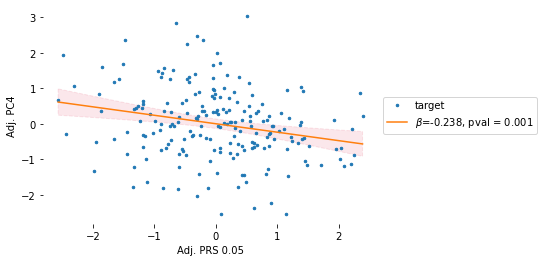

In [20]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)'],
    dependentVar_cols=['AAL 65'])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_0.05'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 0.05', ylabel='Adj. PC4',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

In [21]:
# dependentVar_cols=[i for i in combined.columns if bool(re.search('Imperial \d',i))]
# dependentVar_cols = data_preprocessing.Volumes.extract_GM_Imperial(dependentVar_cols)
# df = european_volumetric_dataset_term
dependentVar_cols = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('AAL \d', i))
]
pca, X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=dependentVar_cols,
    scaling=True,n_components=.8)

In [22]:
np.cumsum(pca.explained_variance_ratio_)

array([0.70763002, 0.73221475, 0.75143805, 0.76905575, 0.78539183,
       0.79872361, 0.8096483 ])

In [23]:
0.05/49

0.0010204081632653062

In [24]:
thresholds = [i for i in df.columns if 'PRS' in i]
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)']+ancestry,
    dependentVar_cols=X_pca)


100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 39.59it/s]


In [25]:
european_volumetric_term_mass_univariate.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
45,Dependent_Var_3,0.026882,0.766669,0.028849,0.731254,-0.597491,0.000002,0.393314,1.735645e-04,0.028621,0.659393,-0.072550,0.262139,-0.060096,0.340852,0.223878,0.000634,-0.056813,0.682898,PRS_0.01
52,Dependent_Var_3,0.042435,0.639105,0.028443,0.735467,-0.609314,0.000001,0.392942,1.815198e-04,0.030893,0.635240,-0.063070,0.328323,-0.046543,0.460038,0.212386,0.000986,-0.089682,0.517314,PRS_0.05
59,Dependent_Var_3,0.050163,0.580310,0.022123,0.793064,-0.602545,0.000002,0.395400,1.736446e-04,0.032623,0.617928,-0.073659,0.258791,-0.044215,0.484137,0.200558,0.001993,-0.106015,0.444889,PRS_0.1
3,Dependent_Var_3,0.051345,0.573192,-0.021614,0.799051,-0.547619,0.000017,0.371470,4.660383e-04,0.029009,0.658585,-0.045322,0.483710,-0.059826,0.348568,0.180442,0.005393,-0.108513,0.436339,PRS_1e-08
31,Dependent_Var_3,0.006035,0.948220,0.009844,0.907318,-0.585995,0.000004,0.394619,1.923674e-04,0.022860,0.727309,-0.051844,0.423861,-0.059635,0.350270,0.185996,0.005822,-0.012753,0.929678,PRS_0.0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,Dependent_Var_4,-0.000883,0.993206,0.023129,0.808645,-0.169172,0.224426,0.129799,2.678855e-01,0.006067,0.934525,0.008434,0.908360,0.080740,0.259354,0.006153,0.933407,0.001866,0.990698,PRS_1e-05
2,Dependent_Var_2,-0.037302,0.708421,-0.227288,0.015209,0.452347,0.001063,-0.227622,4.769554e-02,-0.015192,0.832546,-0.072130,0.308909,0.029896,0.668443,0.005404,0.938712,0.078835,0.605274,PRS_1e-08
60,Dependent_Var_4,0.000222,0.998276,0.022911,0.810196,-0.168915,0.224883,0.129410,2.693809e-01,0.006121,0.934047,0.008342,0.909834,0.080871,0.258396,0.005028,0.944704,-0.000468,0.997617,PRS_0.1
63,Dependent_Var_0,0.024374,0.061986,-0.010059,0.404191,0.040803,0.021284,0.961656,1.488067e-134,-0.004665,0.619569,-0.021014,0.024019,0.004107,0.650207,-0.000531,0.953794,-0.051513,0.010254,PRS_0.5


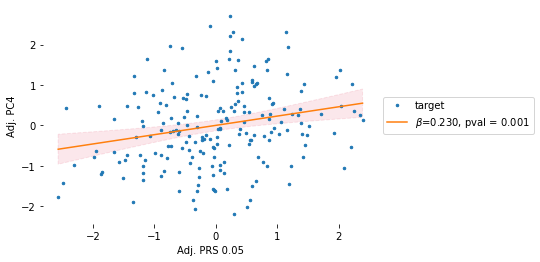

In [26]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','17 ICV (all except bone)'],
    dependentVar_cols=X_pca[:,3].reshape(-1,1))
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_0.05'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 0.05', ylabel='Adj. PC4',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

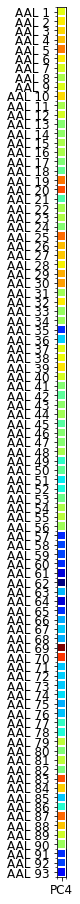

In [43]:
#see the loading matrix of PC4
fig,ax = plt.subplots(1,1,figsize=(20,16))
visualisation.visualise_heatmap(loading_matrix.loc[:,3:3],ax,xlabel=['PC4'],ylabel=loading_matrix.index.tolist())

In [27]:
PRS_loading_matrix = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold'] == 'PRS_0.01'].copy()
PRS_loading_matrix = PRS_loading_matrix.reset_index(drop=True)

In [66]:
len(loading_matrix[3].values[0:90])

90

In [115]:
loading_matrix = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold']=='PRS_0.05'].copy()
loading_labels = [int(i.replace('AAL ','')) for i in loading_matrix.Connection.tolist()]
loading_values = -np.log10(loading_matrix['PRS_pval'].values)

In [116]:
loading_matrix.sort_values(by='PRS_pval').head(10)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,17 ICV (all except bone)_coef,17 ICV (all except bone)_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
715,AAL 65,0.057583,0.322873,0.068126,0.209111,0.056995,0.469508,0.747493,4.313192e-23,-0.012171,0.771312,-0.007646,0.853625,0.010234,0.800461,-0.141710,0.000639,-0.121696,0.172646,PRS_0.05
654,AAL 4,0.016778,0.717550,-0.006445,0.881282,-0.012503,0.842137,0.884703,1.047109e-39,0.030596,0.359814,-0.065234,0.049425,-0.031146,0.335085,0.100513,0.002308,-0.035459,0.617422,PRS_0.05
707,AAL 57,-0.120853,0.011434,-0.066698,0.131533,0.163821,0.011319,0.797380,1.033863e-33,-0.019395,0.569781,0.022485,0.505661,0.053695,0.104693,-0.095758,0.004438,0.255412,0.000525,PRS_0.05
716,AAL 66,0.001733,0.973025,-0.048027,0.314433,0.172421,0.013646,0.754755,4.327543e-28,-0.003976,0.914155,0.025151,0.491078,0.008041,0.821613,-0.096580,0.007870,-0.003662,0.962752,PRS_0.05
718,AAL 68,0.055392,0.201609,0.046737,0.246699,0.015491,0.791505,0.866799,3.412155e-42,0.002307,0.940973,-0.007475,0.808469,0.087928,0.003879,-0.075622,0.013643,-0.117065,0.078358,PRS_0.05
677,AAL 27,0.059168,0.273029,0.047144,0.347725,-0.089177,0.222458,0.876433,3.346754e-32,-0.048879,0.208552,-0.043600,0.256908,0.080790,0.032247,0.091582,0.016394,-0.125045,0.130606,PRS_0.05
652,AAL 2,-0.007973,0.860977,-0.133028,0.001922,0.119196,0.054199,0.844140,2.695985e-38,-0.035239,0.282812,0.005494,0.865469,0.001055,0.973424,0.067665,0.035457,0.016849,0.808889,PRS_0.05
670,AAL 20,0.006828,0.901407,-0.045576,0.374646,0.021809,0.770062,0.833619,3.756126e-29,-0.004278,0.914110,-0.068002,0.084452,0.004849,0.899400,0.080700,0.038268,-0.014431,0.864152,PRS_0.05
735,AAL 85,-0.024171,0.577430,0.089606,0.027323,-0.053974,0.358364,0.926450,1.162679e-45,-0.024054,0.441225,-0.005310,0.863534,0.007489,0.804031,-0.060326,0.048887,0.051082,0.441786,PRS_0.05
675,AAL 25,-0.003177,0.957764,0.100771,0.072184,-0.208051,0.011051,0.914307,1.826228e-29,0.022274,0.606025,-0.045150,0.291397,-0.052945,0.205635,0.082959,0.050211,0.006714,0.941693,PRS_0.05


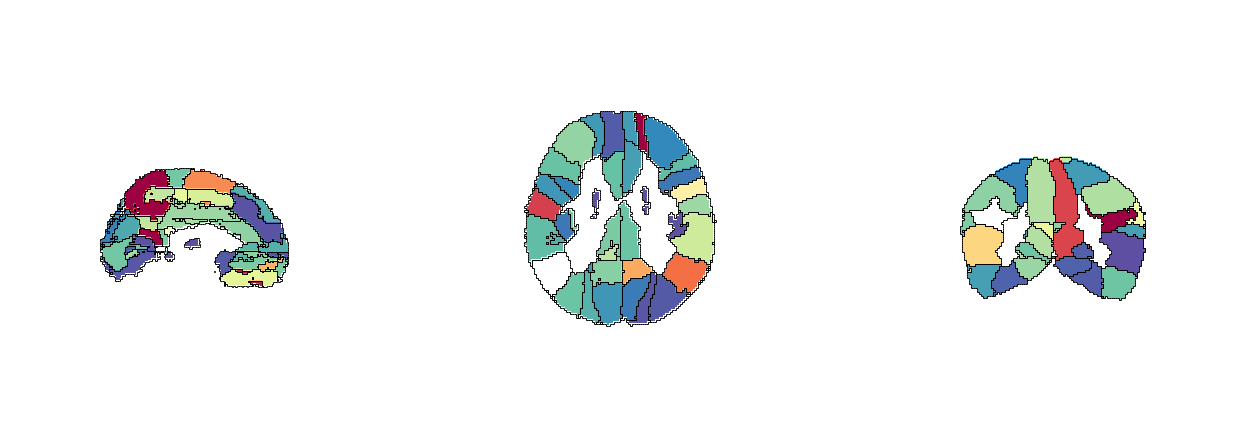

In [127]:
fig, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['sagittal','axial','coronal'],regions_to_hide=[65],plot_values=dict(zip(loading_labels,loading_values)),colorbar=False,atlas_file = '../../dataset/visualise/AAL/infant-neo-aal.nii.gz',orientation='vertical',cmap_reversed=True)

In [29]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/infant-neo-aal.nii.gz')

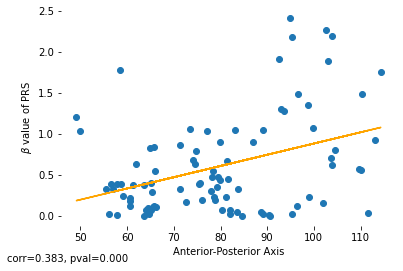

In [34]:
visualisation.plot_correlation(ROIs_coord.loc[0:89,'Z'],-np.log10(PRS_loading_matrix.loc[0:89,'PRS_pval'].values),xlabel='Anterior-Posterior Axis',ylabel=r'$\beta$ value of PRS')
# plt.hlines(-np.log10(0.05),50,110)
sns.despine(left=True,bottom=True)

In [55]:
corr_matrix = []
adjusted_X = []
dependentVar_cols = [
    i for i in european_volumetric_dataset_term.columns
    if bool(re.search('AAL \d', i))
]
for region in dependentVar_cols:
    model,_ = data_exploration.MassUnivariate.mass_univariate(df,
                                                   cat_independentVar_cols=['Gender'],
                                                   cont_independentVar_cols=['PMA_vol','GA_vol','17 ICV (all except bone)'],
                                                   dependentVar_cols=[region])
    adjusted_X.append(model.resid)
#     corr_matrix.append(np.corrcoef(model.resid,X_pca[:,3])[0][1])

In [56]:
adjusted_X = np.array(adjusted_X).T

In [57]:
pca, new_X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=adjusted_X,
    scaling=True,n_components=5)

In [58]:
# df = european_volumetric_dataset_term
thresholds = [i for i in df.columns if 'PRS' in i]
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=new_X_pca)

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 48.04it/s]


In [59]:
0.05/3/7

0.0023809523809523807

In [60]:
european_volumetric_term_mass_univariate.sort_values(by=['PRS_pval'])

,Connection,const_coef,const_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,threshold
32,Dependent_Var_2,-2.081668e-17,1.0,0.033502,0.631681,-0.033370,0.635315,-0.186442,0.007041,0.228531,0.001106,PRS_0.01
37,Dependent_Var_2,-2.081668e-17,1.0,0.033507,0.633447,-0.023221,0.741611,-0.171490,0.013178,0.204770,0.003291,PRS_0.05
27,Dependent_Var_2,-2.081668e-17,1.0,0.034443,0.625896,-0.021720,0.758968,-0.175738,0.011565,0.182320,0.009221,PRS_0.001
21,Dependent_Var_1,6.938894e-18,1.0,-0.008720,0.903107,0.036521,0.610057,-0.032718,0.642183,-0.165663,0.019203,PRS_0.0001
42,Dependent_Var_2,-2.081668e-17,1.0,0.033369,0.637939,-0.028260,0.692753,-0.168661,0.015538,0.163711,0.020446,PRS_0.1
52,Dependent_Var_2,-2.081668e-17,1.0,0.037301,0.599672,-0.020498,0.773068,-0.172077,0.013650,0.162629,0.020790,PRS_1
47,Dependent_Var_2,-2.081668e-17,1.0,0.037336,0.599819,-0.016551,0.815676,-0.172730,0.013411,0.156438,0.025947,PRS_0.5
23,Dependent_Var_3,6.938894e-18,1.0,-0.046485,0.517298,-0.032169,0.653801,0.020202,0.774521,-0.157441,0.026209,PRS_0.0001
12,Dependent_Var_2,-2.081668e-17,1.0,0.020179,0.776040,-0.003347,0.962330,-0.181380,0.009979,0.141322,0.043111,PRS_1e-06
17,Dependent_Var_2,-2.081668e-17,1.0,0.030262,0.670559,-0.017867,0.802297,-0.170962,0.014627,0.137189,0.050820,PRS_1e-05


In [47]:
loading_values = loading_matrix.loc[0:89,2].values

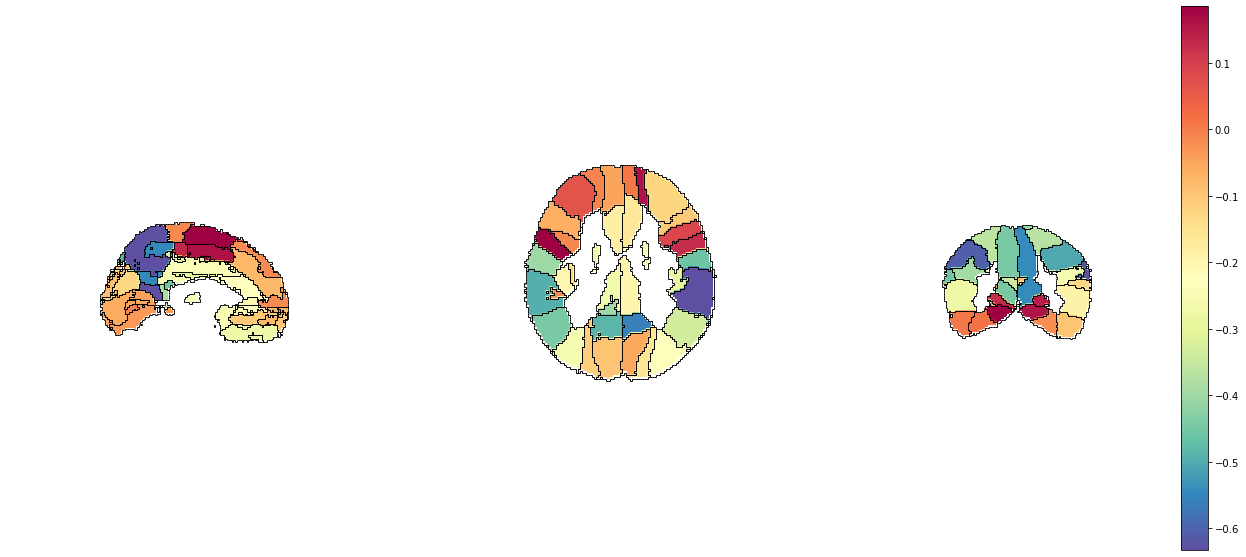

In [43]:
fig, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['sagittal','axial','coronal'],plot_values_labels=list(range(1,91)),plot_values_values=loading_values,colorbar=True,atlas_file = '../../dataset/visualise/AAL/infant-neo-aal.nii.gz',orientation='vertical',cmap_reversed=True)

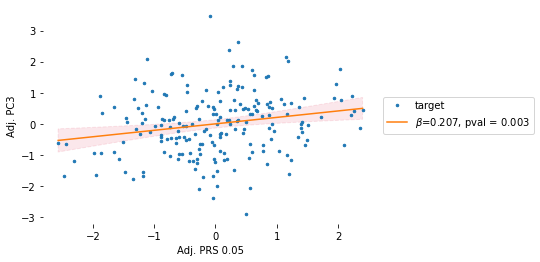

In [54]:
# PC4 was associated with the PRS 0.01 and 0.05
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_0.05'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, new_X_pca[:,2], xlabel='Adj. PRS 0.05', ylabel='Adj. PC3',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

In [5]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates('../../dataset/visualise/AAL/infant-neo-aal.nii.gz')

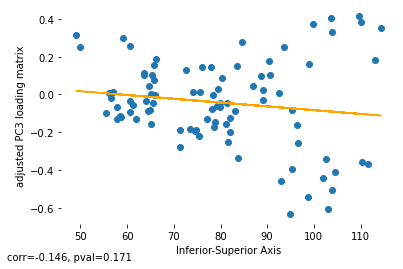

In [55]:
visualisation.plot_correlation(ROIs_coord.loc[0:89,'Z'],loading_values,xlabel='Inferior-Superior Axis',ylabel=r'adjusted PC3 loading matrix')
# plt.hlines(-np.log10(0.05),50,110)
sns.despine(left=True,bottom=True)

## Imperial Atlas

In [126]:
df.shape

(205, 4520)

In [89]:
df = data_preprocessing.Volumes.Group_Imperial_volumes(df,grouping='gmwm2gether',remove_duplicated=False)
deepGM = data_preprocessing.Volumes.extract_deepGM_Imperial([i for i in df.columns if bool(re.search('Imperial \d',i))])
df = df.drop(columns=['Imperial 83','Imperial 84','Imperial 85'])




In [128]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
# df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[i for i in df.columns if bool(re.search('Imperial \d',i))]

european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol','Intracranial_Imperial']+ancestry,
    dependentVar_cols=dependentVar_cols)

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  5.91it/s]


In [129]:
european_volumetric_term_mass_univariate.sort_values(by='PRS_pval').groupby('Connection').head(1).head(10)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
882,Imperial 13,0.077160,0.148111,-0.009908,0.840639,0.245484,7.825003e-04,0.630785,1.616509e-20,-0.017474,0.649041,-0.000073,0.998474,-0.042786,0.248553,0.132409,0.000529,-0.163071,4.648846e-02,PRS_1
603,Imperial 82,0.228960,0.000025,-0.040115,0.415739,-0.262480,3.149638e-04,0.937004,4.999536e-36,-0.024245,0.524491,-0.030886,0.415341,0.067650,0.068407,-0.110212,0.003974,-0.483885,1.269255e-08,PRS_0.01
602,Imperial 81,0.179831,0.000732,-0.011045,0.820394,-0.293364,4.943663e-05,0.975659,1.412995e-38,-0.002711,0.942533,-0.011943,0.749649,0.082902,0.024083,-0.103620,0.006064,-0.380055,4.389396e-06,PRS_0.01
646,Imperial 38,0.008329,0.767155,0.004038,0.877355,0.376399,5.544085e-19,0.654228,1.948332e-50,-0.008129,0.688037,-0.009313,0.642163,0.065762,0.000925,-0.049602,0.012798,-0.017602,6.825944e-01,PRS_0.05
35,Imperial 36,0.021619,0.351824,-0.014394,0.505618,0.267553,6.659117e-15,0.767527,1.590584e-72,-0.008236,0.622208,-0.006370,0.698929,0.006474,0.690063,0.040109,0.014904,-0.045689,1.985377e-01,PRS_1e-08
411,Imperial 64,0.074637,0.273304,0.052386,0.397720,-0.306117,8.438598e-04,0.886875,3.251772e-24,0.061322,0.202190,0.023177,0.625127,-0.044447,0.341705,0.114617,0.019930,-0.157738,1.370755e-01,PRS_0.0001
14,Imperial 15,0.071732,0.301960,-0.113453,0.080504,0.324298,7.567949e-04,0.490228,3.979761e-09,0.058355,0.243953,0.057972,0.240162,-0.008201,0.865920,0.113337,0.021376,-0.151598,1.541200e-01,PRS_1e-08
384,Imperial 37,0.008621,0.718040,-0.024323,0.263496,0.282801,3.186693e-16,0.760526,1.237509e-71,-0.017027,0.312552,-0.017866,0.283710,0.005230,0.749620,0.039388,0.022605,-0.018220,6.236992e-01,PRS_0.0001
222,Imperial 49,-0.063173,0.466828,0.042921,0.594565,-0.263087,2.628760e-02,0.660585,2.894715e-10,-0.005989,0.923507,0.109970,0.075409,0.043667,0.472374,0.139377,0.023162,0.133511,3.146966e-01,PRS_1e-06
98,Imperial 12,0.088273,0.080506,-0.038880,0.404560,0.337300,1.781095e-06,0.597984,2.034173e-20,-0.007770,0.830546,0.008799,0.805398,-0.013266,0.706193,-0.081715,0.023240,-0.186557,1.613802e-02,PRS_1e-07


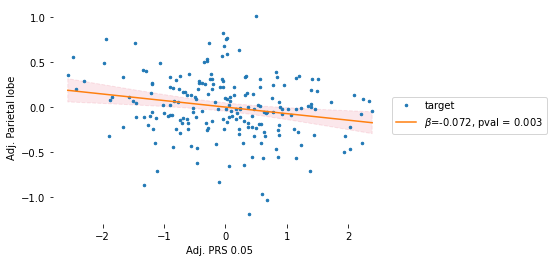

In [80]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=['Imperial 39'])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_0.05'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 0.05', ylabel='Adj. Parietal lobe L',markersize=5,scaling='x')
sns.despine(left=True,right=True,bottom=True,top=True)

In [13]:
len(combined.columns)

84

In [82]:
# euro_WM = data_preprocessing.Volumes.extract_WM_Imperial(df)
# euro_GM = data_preprocessing.Volumes.extract_GM_Imperial(df)
# euro_DGM = data_preprocessing.Volumes.extract_deepGM_Imperial(df)
# deepGM = data_preprocessing.Volumes.extract_deepGM_Imperial([i for i in df.columns if bool(re.search('Imperial \d',i))])
combined = df[[
    i for i in df.columns
    if bool(re.search('Imperial \d', i))
]].copy()
# combined.drop(columns=deepGM,inplace=True)
# combined = pd.concat([euro_WM,euro_GM],axis=1)
# combined = df[[i for i in df.columns if 'PRS' in i]]
correlation_matrix = np.corrcoef(combined, rowvar=False)
data_exploration.matSpDLite(correlation_matrix, alpha=0.05)

Effective Number of Independent Variables [Veff] is 30.537095519088055
Effective Number of Independent Variables [VeffLi] (Using equation 5 of Li and Ji 2005) is 20.0
The adjusted multiple testing correction p-val is alpha/lower(Meff) = 0.002499999999999996


In [61]:
dependentVar_cols = [
    i for i in df.columns
    if bool(re.search('Imperial \d', i))
]
pca, X_pca, loading_matrix = data_preprocessing_high_dimension.FeatureReduction.perform_PCA(
    df=df,
    dependentVar_cols=dependentVar_cols,
    scaling=True,n_components=.8)

In [83]:
0.05/20/7

0.00035714285714285714

In [62]:
np.cumsum(pca.explained_variance_ratio_)

array([0.66680518, 0.70285951, 0.72936714, 0.75284757, 0.77321135,
       0.78997202, 0.80487997])

In [63]:
ancestry = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
# df = european_volumetric_dataset_term.copy()
thresholds = [i for i in df.columns if 'PRS' in i]
dependentVar_cols=[i for i in df.columns if bool(re.search('Imperial \d',i))]


european_volumetric_term_mass_univariate = data_exploration.MassUnivariate.calculate_mass_univariate_across_multiple_thresholds(
    df,
    thresholds=thresholds,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol', 'PMA_vol','Intracranial_Imperial']+ancestry,
    dependentVar_cols=X_pca)

100%|███████████████████████████████████████████| 11/11 [00:00<00:00, 39.64it/s]


In [64]:
european_volumetric_term_mass_univariate.sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
10,Dependent_Var_3,0.104430,0.251763,-0.020866,0.804448,-0.463442,0.000239,0.237552,2.354691e-02,0.204492,0.002088,0.115645,0.074491,-0.039549,0.534357,0.131863,0.042549,-0.220702,0.113944,PRS_1e-07
3,Dependent_Var_3,0.108964,0.231672,-0.037402,0.658978,-0.459112,0.000283,0.236233,2.451209e-02,0.200315,0.002511,0.119052,0.066340,-0.039214,0.537990,0.127802,0.047279,-0.230285,0.098819,PRS_1e-08
29,Dependent_Var_1,0.133309,0.189615,-0.110904,0.230159,0.411585,0.002539,-0.388355,7.459812e-04,0.006594,0.926552,-0.038944,0.581840,-0.012512,0.857346,-0.125853,0.085436,-0.281735,0.075200,PRS_0.0001
15,Dependent_Var_1,0.099867,0.316180,-0.115315,0.213224,0.407979,0.002800,-0.375062,1.185582e-03,0.009832,0.890691,-0.044773,0.526480,-0.013230,0.849348,-0.114803,0.101839,-0.211058,0.166297,PRS_1e-06
13,Dependent_Var_6,0.074229,0.451939,0.017062,0.851844,-0.352724,0.009271,0.219763,5.288510e-02,-0.047090,0.508397,-0.129793,0.064888,-0.040526,0.556950,-0.100748,0.151808,-0.156875,0.299113,PRS_1e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,Dependent_Var_3,0.113645,0.218891,-0.021337,0.802992,-0.492919,0.000102,0.259358,1.407378e-02,0.191022,0.004249,0.121757,0.065377,-0.026287,0.682229,-0.006515,0.921059,-0.240177,0.091036,PRS_0.01
58,Dependent_Var_2,-0.093037,0.357056,0.023006,0.806303,0.168247,0.219310,-0.000428,9.970374e-01,-0.020814,0.774836,0.031519,0.663687,0.057790,0.411349,-0.005094,0.943064,0.196625,0.203445,PRS_0.1
20,Dependent_Var_6,0.067821,0.493708,0.017185,0.851857,-0.329783,0.014813,0.202608,7.563492e-02,-0.037027,0.603142,-0.133812,0.058184,-0.050672,0.465053,0.004268,0.951104,-0.143332,0.344273,PRS_1e-06
49,Dependent_Var_0,0.080109,0.002997,-0.052852,0.034300,0.120208,0.001035,0.876797,1.773038e-72,-0.000935,0.961160,-0.010665,0.574972,-0.002961,0.873354,0.000144,0.993859,-0.169302,0.000049,PRS_0.05


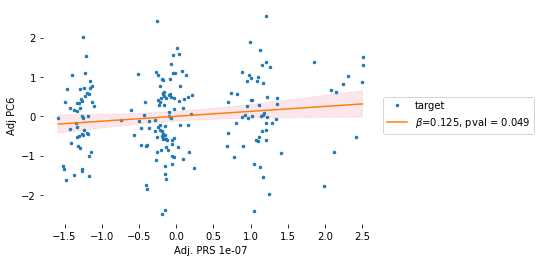

In [65]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=X_pca[:,3].reshape(-1,1))
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_1e-07'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 1e-07',ylabel='Adj PC6',markersize=5,scaling='x')
sns.despine(left=True,right=True,bottom=True,top=True)

In [66]:
loading_values = loading_matrix[3].values
loading_labels = [int(i.replace('Imperial ','')) for i in loading_matrix.index.tolist()]

In [120]:
loading_matrix = european_volumetric_term_mass_univariate[european_volumetric_term_mass_univariate['threshold']=='PRS_0.05'].copy()

In [122]:
loading_labels = [int(i.replace('Imperial ','')) for i in loading_matrix.Connection.tolist()]
loading_values = -np.log10(loading_matrix['PRS_pval'].values)

In [99]:
plot_values=dict(zip(loading_labels,loading_values))

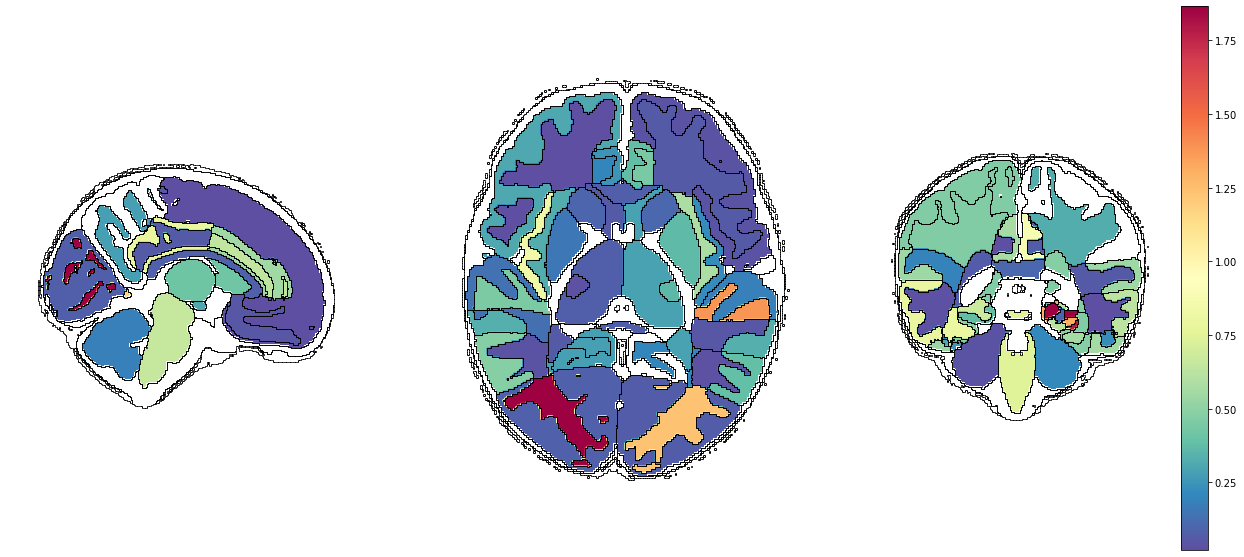

In [119]:
fig, map_view_dict = visualisation.Brainmap.plot_segmentation(map_view=['sagittal','axial','coronal'],regions_to_hide=[83,84,85,39],plot_values=dict(zip(loading_labels,loading_values)),colorbar=True,atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz',orientation='vertical',cmap_reversed=True)

In [102]:
loading_matrix.sort_values(by='PRS_pval').head(10)

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
626,Imperial 39,0.106360,0.002147,-0.023500,0.460970,0.145867,0.001887,0.821106,3.166235e-52,-0.021323,0.387317,-0.022125,0.364891,0.068321,0.004547,-0.074275,0.002290,-0.224782,0.000027,PRS_0.05
669,Imperial 82,0.106360,0.002147,-0.023500,0.460970,0.145867,0.001887,0.821106,3.166235e-52,-0.021323,0.387317,-0.022125,0.364891,0.068321,0.004547,-0.074275,0.002290,-0.224782,0.000027,PRS_0.05
625,Imperial 38,0.077725,0.027281,-0.001627,0.960144,0.122770,0.010193,0.833785,7.581033e-52,-0.006690,0.790535,-0.013127,0.598618,0.074751,0.002419,-0.071013,0.004271,-0.164265,0.002429,PRS_0.05
668,Imperial 81,0.077725,0.027281,-0.001627,0.960144,0.122770,0.010193,0.833785,7.581033e-52,-0.006690,0.790535,-0.013127,0.598618,0.074751,0.002419,-0.071013,0.004271,-0.164265,0.002429,PRS_0.05
594,Imperial 7,0.103206,0.116151,-0.130023,0.033834,0.331447,0.000239,0.524381,3.301860e-11,0.007316,0.876638,-0.081357,0.082343,-0.047043,0.302648,0.072285,0.117424,-0.218116,0.030473,PRS_0.05
640,Imperial 53,0.103206,0.116151,-0.130023,0.033834,0.331447,0.000239,0.524381,3.301860e-11,0.007316,0.876638,-0.081357,0.082343,-0.047043,0.302648,0.072285,0.117424,-0.218116,0.030473,PRS_0.05
589,Imperial 2,0.055418,0.420161,0.020557,0.747719,-0.019350,0.835210,0.744486,6.750234e-18,-0.014436,0.770296,0.001933,0.968490,0.049428,0.301845,-0.075442,0.119272,-0.117120,0.265883,PRS_0.05
607,Imperial 20,0.100870,0.055257,-0.027963,0.566227,0.002207,0.975178,0.832929,3.224413e-31,0.027544,0.465254,-0.012880,0.729998,-0.046134,0.206612,0.057497,0.119455,-0.213179,0.008379,PRS_0.05
650,Imperial 63,0.100870,0.055257,-0.027963,0.566227,0.002207,0.975178,0.832929,3.224413e-31,0.027544,0.465254,-0.012880,0.729998,-0.046134,0.206612,0.057497,0.119455,-0.213179,0.008379,PRS_0.05
616,Imperial 29,0.004149,0.935496,0.098326,0.040297,-0.128259,0.065803,0.929503,3.513508e-37,-0.013221,0.720120,0.028633,0.433366,-0.003974,0.911304,-0.053962,0.135315,-0.008768,0.910997,PRS_0.05


In [70]:
ROIs_coord = visualisation.Brainmap.get_ROIs_coordinates(atlas_file = '../../dataset/visualise/Imperial/atlas_t40.nii.gz')

In [71]:
ROIs_coord = ROIs_coord[~ROIs_coord['Label'].isin([83,84,85])]

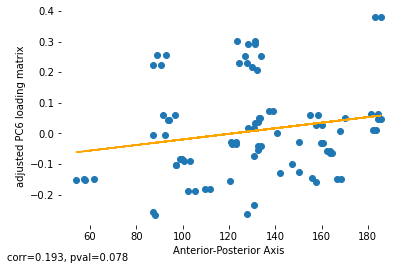

In [74]:
visualisation.plot_correlation(ROIs_coord['Y'],loading_values,xlabel='Anterior-Posterior Axis',ylabel=r'adjusted PC6 loading matrix')
# plt.hlines(-np.log10(0.05),50,110)
sns.despine(left=True,bottom=True)

In [ ]:
df = mixed_volumetric_dataset_term
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
thresholds = [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]

summary_table = data_exploration.MassUnivariate.print_summary_table(df,
                                                    cat_independentVar_cols=['Gender'],
                                                    cont_independentVar_cols=['GA_vol', 'PMA_vol', 'Intracranial_Imperial']
                                                                    + ancestry_list,
                                                    dependentVar_cols=dependentVar_cols,
                                                    thresholds=thresholds)

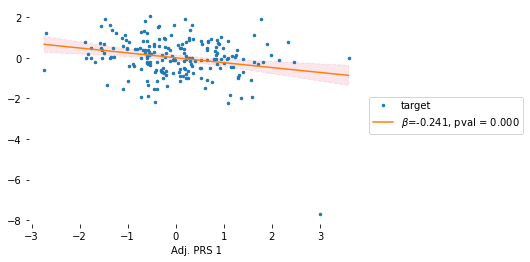

In [149]:
# PC4 was associated with the PRS 0.01 and 0.05
model1, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cat_independentVar_cols=['Gender'],
    cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial'],
    dependentVar_cols=['Imperial 38'])
model2, _ = data_exploration.MassUnivariate.mass_univariate(
    df,
    cont_independentVar_cols=ancestry,
    dependentVar_cols=['PRS_1e-06'])
# ax = plt.subplot(111)
visualisation.plot_Linear_Reg(model2.resid, model1.resid, xlabel='Adj. PRS 1',markersize=5)
sns.despine(left=True,right=True,bottom=True,top=True)

We get the following summary table of R2, beta and p-value of association between PRS and brain volumes

In [14]:
df = mixed_volumetric_dataset_term
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
thresholds = [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]

summary_table = data_exploration.MassUnivariate.print_summary_table(df,
                                                    cat_independentVar_cols=['Gender'],
                                                    cont_independentVar_cols=['GA_vol', 'PMA_vol', 'Intracranial_Imperial']
                                                                    + ancestry_list,
                                                    dependentVar_cols=['Imperial 79', 'Imperial 58', 'Imperial 12', 'WM_sum_Imperial'],
                                                    thresholds=thresholds)

In [15]:
summary_table

GA_vol       PMA_vol  \
Imperial 79     PRS_1e-08 R2     2.151483e-07  5.581806e-02   
                          Beta   1.163305e-03 -4.655917e-01   
                          P_val  9.737014e-01  2.193130e-16   
                PRS_1e-07 R2     2.151483e-07  5.581806e-02   
                          Beta  -4.715114e-05 -4.633134e-01   
...                                       ...           ...   
WM_sum_Imperial PRS_0.5   Beta  -2.090412e-02 -3.504964e-01   
                          P_val  4.976230e-01  7.648056e-13   
                PRS_1     R2     2.069066e-04  3.168293e-02   
                          Beta  -2.117077e-02 -3.491695e-01   
                          P_val  4.918391e-01  9.191190e-13   

                                 Intracranial_Imperial  mixed_Anc_PC1  \
Imperial 79     PRS_1e-08 R2              4.345161e-01       0.000042   
                          Beta            1.111430e+00       0.001041   
                          P_val           1.504568e-69       0.972560   
                PRS_1e-07 R2              4.345161e-01       0.000042   
                          Beta            1.109018e+00      -0.000937   
...                                                ...            ...   
WM_sum_Imperial PRS_0.5   Beta            1.092073e+00      -0.000195   
                          P_val           1.989428e-78       0.995132   
                PRS_1     R2              4.196961e-01       0.000481   
                          Beta            1.090843e+00      -0.002398   
                          P_val           2.625290e-78       0.940021   

                                 mixed_Anc_PC2  mixed_Anc_PC3  mixed_Anc_PC4  \
Imperial 79     PRS_1e-08 R2          0.000154       0.001059       0.000422   
                          Beta       -0.029123      -0.063549       0.024028   
                          P_val       0.570351       0.226530       0.406298   
                PRS_1e-07 R2          0.000154       0.001059       0.000422   
                          Beta       -0.028789      -0.063398       0.024302   
...                                        ...            ...            ...   
WM_sum_Imperial PRS_0.5   Beta        0.024430       0.001851       0.022922   
                          P_val       0.585327       0.968076       0.363892   
                PRS_1     R2          0.000128       0.000014       0.000426   
                          Beta        0.024602       0.002582       0.022865   
                          P_val       0.582377       0.955443       0.364681   

                                 mixed_Anc_PC5  Gender  PRS_1e-08  ...  \
Imperial 79     PRS_1e-08 R2          0.000126     0.0   0.000000  ...   
                          Beta       -0.009900     NaN  -0.074038  ...   
                          P_val       0.721709     NaN   0.005687  ...   
                PRS_1e-07 R2          0.000126     0.0        NaN  ...   
                          Beta       -0.010466     NaN        NaN  ...   
...                                        ...     ...        ...  ...   
WM_sum_Imperial PRS_0.5   Beta       -0.020695     NaN        NaN  ...   
                          P_val       0.394847     NaN        NaN  ...   
                PRS_1     R2          0.000294     0.0        NaN  ...   
                          Beta       -0.020826     NaN        NaN  ...   
                          P_val       0.391380     NaN        NaN  ...   

                                 PRS_1e-07  PRS_1e-06  PRS_1e-05  PRS_0.0001  \
Imperial 79     PRS_1e-08 R2           NaN        NaN        NaN         NaN   
                          Beta         NaN        NaN        NaN         NaN   
                          P_val        NaN        NaN        NaN         NaN   
                PRS_1e-07 R2      0.000000        NaN        NaN         NaN   
                          Beta   -0.076941        NaN        NaN         NaN   
...                                    ...        ...        ...         ..

We get the following plots

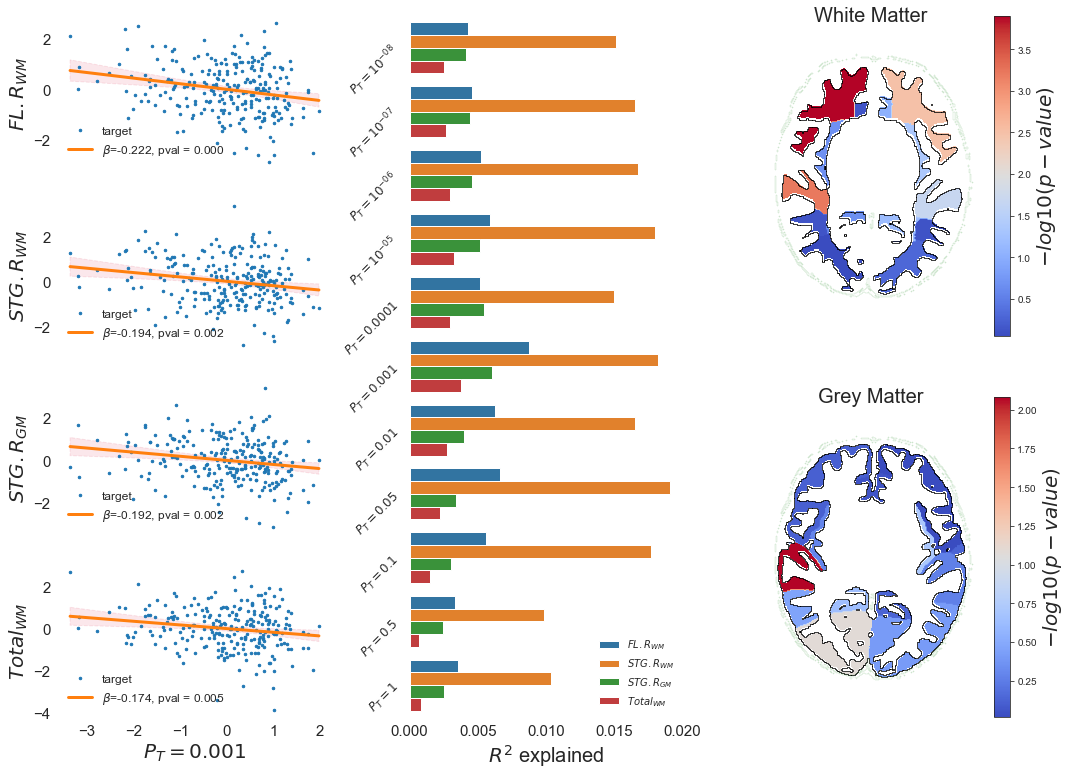

In [138]:
sns.set_style('white')
fig,axes = plt.subplots(4,3,sharex = True,figsize=(15,11))
# fig = plt.figure(figsize=(20,10))
# ax1 = plt.subplot(4,3,1)
# ax2 = plt.subplot(4,3,4)
# ax3 = plt.subplot(4,3,7)
# ax4 = plt.subplot(4,3,10)
for ax in axes[:,1:].flatten():
    ax.remove()
bar_plot = plt.subplot(132)
WM_plot = plt.subplot(233)
GM_plot = plt.subplot(236)
# plt.tight_layout(w_pad =.5, h_pad=.2)
dependent_var = ['Imperial 79','Imperial 58','Imperial 12','WM_sum_Imperial']
ylbl = ['$FL.R_{WM}$', '$STG.R_{WM}$', '$STG.R_{GM}$','$Total_{WM}$']
threshold = 'PRS_0.001'
thresholds_label = '$P_T = 0.001$'
ancestry_list = ['mixed_Anc_PC' + str(i) for i in range(1,4)]
# axes = axes.flatten()
df = mixed_volumetric_dataset_term
# draw the scatter plot
for ax,dependent_variable, ylabel in zip(axes[:,0],dependent_var,ylbl):
    model, _ = data_exploration.MassUnivariate.mass_univariate(df = df,
                                                              cat_independentVar_cols=['Gender'],
                                                              cont_independentVar_cols=[
                                                                  'GA_vol','PMA_vol','Intracranial_Imperial'
                                                              ]+ancestry_list,
                                                              dependentVar_cols=[dependent_variable])
    visualisation.plot_Linear_Reg(x = df[[threshold]].values,
                                 y = model.resid.values,
                                 data = df,
                                 ylabel = ylabel,
                                 xlabel = f'{threshold}',
                                 axes=ax,legend_loc='inside',linewidth = 3,markersize=5)
    ax.set_ylabel(ylabel,fontsize=20)
    ax.set_xlabel(None,fontsize=20)
    ax.tick_params(axis='both',which='major',labelsize=15)
    ax.legend(loc='lower left',fontsize=12,frameon=False)
    sns.despine(bottom=True,left=True,right=True)
axes[-1,0].set_xlabel(f'{thresholds_label}',fontsize=20)

    
#draw the barplot of R-squared explained
Rsquared_explained_list = defaultdict(dict)
for dependent_variable in dependent_var:
    Rsquared_explained_list[dependent_variable] = defaultdict(list)
    for threshold in [i for i in european_volumetric_dataset_term.columns if 'PRS' in i]:
        Rsquared_explained_list[dependent_variable][threshold] = data_exploration.MassUnivariate.calculate_R_squared_explained(df = df,col_to_drop=threshold,cat_independentVar_cols=['Gender'],cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry_list,dependentVar_cols=[dependent_variable])
Rsquared_explained_pd = pd.DataFrame(Rsquared_explained_list)
Rsquared_explained_pd.columns = ylbl

Rsquared_explained_pd = pd.DataFrame(Rsquared_explained_pd.unstack()).reset_index()
Rsquared_explained_pd.columns = ['Region','Threshold','$R^{2}$ explained']

g = sns.barplot(y = 'Threshold',x = '$R^{2}$ explained', data = Rsquared_explained_pd,hue = 'Region',ax = bar_plot)
# g.set_xlabel(rotation=90)
sns.despine(bottom=True,left=True,right=True)
bar_plot.set_xlabel('$R^{2}$ explained',fontsize=20)
bar_plot.set_ylabel(None,fontsize=20)
g.set_yticklabels(['$P_T = 10^{-08}$','$P_T = 10^{-07}$',
                     '$P_T = 10^{-06}$','$P_T = 10^{-05}$',
                     '$P_T = 0.0001$','$P_T = 0.001$',
                     '$P_T = 0.01$','$P_T = 0.05$',
                    '$P_T = 0.1$','$P_T = 0.5$','$P_T = 1$'],fontsize=12,rotation = 45)
g.tick_params(axis='x', labelsize=15)
bar_plot.legend(frameon=False)

#import the atlas
import nibabel as nib
FOLDER_PATH = f'{dataset_path}/visualise/Imperial/'  # please change to your own path

atlas_file = nib.load(FOLDER_PATH + 'atlas_t40.nii.gz')
atlas_aff = atlas_file.affine
atlas = atlas_file.get_fdata()

df = mixed_volumetric_term_mass_univariate[mixed_volumetric_term_mass_univariate['threshold'] == 'PRS_0.001'].copy()

df = df[[bool(re.search(r'[1-9]',i)) for i in df['Connection']]].sort_values(by='PRS_pval').reset_index(drop=True)
df['Connection_ID'] = [int(i.split(' ')[1]) for i in df['Connection']]

# Create a new volume of the same size as the atlas
atlas_coeffs_WM = np.zeros_like(atlas)
atlas_coeffs_GM = np.zeros_like(atlas)


WM_df = extract_WM_Imperial(df).reset_index(drop=True)
GM_df = extract_GM_Imperial(df).reset_index(drop=True)
# fig,axes = plt.subplots(1,2,figsize=(20,10))
# Here you will replace each index (0...87) from the atlas with the coefficients you want to plot
for i in WM_df['Connection_ID'].tolist():
    atlas_coeffs_WM[atlas == i] = -np.log10(WM_df.loc[WM_df['Connection_ID'] == i,'PRS_pval'].values)

for i in GM_df['Connection_ID'].tolist():
    atlas_coeffs_GM[atlas == i] = -np.log10(GM_df.loc[GM_df['Connection_ID'] == i,'PRS_pval'].values)


# im1 = WM_plot.imshow(np.rot90(atlas_coeffs_WM[:, :, atlas_coeffs_WM.shape[2]//2]),cmap='coolwarm')
# im2 = GM_plot.imshow(np.rot90(atlas_coeffs_GM[:, :, atlas_coeffs_GM.shape[2]//2]),cmap='coolwarm')

import copy
from matplotlib.collections import LineCollection

cmap = copy.copy(plt.cm.get_cmap('coolwarm'))
cmap.set_bad(alpha=0)

# atlas_coeffs_WM[atlas==84] = 0.1
WM_atlas = atlas_coeffs_WM[:, :, atlas_coeffs_WM.shape[2]//2]
GM_atlas = atlas_coeffs_GM[:, :, atlas_coeffs_GM.shape[2]//2]

WM_atlas[WM_atlas==0] = np.nan
GM_atlas[GM_atlas==0] = np.nan

im1 = WM_plot.imshow(np.rot90(WM_atlas),cmap=cmap)
im2 = GM_plot.imshow(np.rot90(GM_atlas),cmap=cmap)

WM_atlas[np.isnan(WM_atlas)] = 0
GM_atlas[np.isnan(GM_atlas)] = 0

brain_background = np.zeros(atlas.shape)
brain_background[atlas==84] = 1
brain_background = brain_background[:, :, brain_background.shape[2]//2]

cl_WM = LineCollection(visualisation.get_edges(np.rot90(WM_atlas)),lw=1,color='k')
WM_plot.add_collection(cl_WM)

cl_GM = LineCollection(visualisation.get_edges(np.rot90(GM_atlas)),lw=1,color='k')
GM_plot.add_collection(cl_GM)


cl_background = LineCollection(visualisation.get_edges(np.rot90(brain_background)),lw=0.1,color='g')
WM_plot.add_collection(cl_background)
cl_background = LineCollection(visualisation.get_edges(np.rot90(brain_background)),lw=0.1,color='g')
GM_plot.add_collection(cl_background)

for im,ax in zip([im1,im2],[WM_plot,GM_plot]):
    cbar = plt.colorbar(im,ax=ax)
    ax.set_xticks([])
    ax.set_yticks([])
    cbar.set_label('$-log10(p-value)$', fontsize=20)
WM_plot.set_title('White Matter',fontsize=20)
GM_plot.set_title('Grey Matter', fontsize=20)
# WM_plot.set_ylabel('White Matter',fontsize=20)
# GM_plot.set_ylabel('Grey Matter',fontsize=20)
plt.tight_layout()
fig.savefig(f'{preprocessed_dataset_path}/output_plot/all_plots_mixed.svg')

# Other tests

## Stability test

1. We halve the sample into 2 equal data sets and see if similar results are given
2. We separate into high and low risks

### Halving the samples

In [45]:
common_list_WM = defaultdict(pd.DataFrame)
common_list_GM = defaultdict(pd.DataFrame)
ancestry = ['mixed_Anc_PC'+str(i) for i in range(1,6)]
df = mixed_volumetric_dataset_term
thresholds = [i for i in mixed_volumetric_dataset_term.columns if 'PRS' in i]
result_dict = defaultdict(dict)
for run in range(10):
    result_dict[f'split_{run+1}']=defaultdict(dict)
    for threshold in thresholds:
        result_dict[f'split_{run+1}'][threshold]=defaultdict(dict)
        result_dict[f'split_{run+1}'][threshold]['Set_1']=defaultdict(dict)
        result_dict[f'split_{run+1}'][threshold]['Set_2']=defaultdict(dict)
        
        train, test = data_exploration.train_test_split_modified(
            df,
            'GA_vol',
            'Gender',
            'cohort',
            random_state=run)
        _,train_mass_univariate = data_exploration.MassUnivariate.mass_univariate(
            train, cat_independentVar_cols=['Gender'],
            cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry,
            dependentVar_cols=['WM_sum_Imperial','Imperial 79','Imperial 58','Imperial 12'])

        _,test_mass_univariate = data_exploration.MassUnivariate.mass_univariate(
            test, cat_independentVar_cols=['Gender'], cont_independentVar_cols=['GA_vol','PMA_vol','Intracranial_Imperial',threshold]+ancestry,
            dependentVar_cols=['WM_sum_Imperial','Imperial 79','Imperial 58','Imperial 12'])
        train_mass_univariate = train_mass_univariate.rename({threshold+'_pval':'PRS_pval',
                                 threshold+'_coef':'PRS_coef'},axis=1)
        test_mass_univariate = test_mass_univariate.rename({threshold+'_pval':'PRS_pval',
                                 threshold+'_coef':'PRS_coef'},axis=1)
        
        for col,colname in zip(train_mass_univariate.index.tolist(),['Total WM',
                                                                    'FL.R_WM',
                                                                    'STG.R_WM',
                                                                    'STG.R_GM']):
            result_dict[f'split_{run+1}'][threshold]['Set_1'][colname]['p_value'] = train_mass_univariate.loc[col,'PRS_pval']
            result_dict[f'split_{run+1}'][threshold]['Set_1'][colname]['beta'] = train_mass_univariate.loc[col,'PRS_coef']
            result_dict[f'split_{run+1}'][threshold]['Set_2'][colname]['p_value'] = test_mass_univariate.loc[col,'PRS_pval']
            result_dict[f'split_{run+1}'][threshold]['Set_2'][colname]['beta'] = test_mass_univariate.loc[col,'PRS_coef']

In [46]:
halving_samples = pd.DataFrame.from_dict({(s, t, st, bv): result_dict[s][t][st][bv]
                        for s in result_dict.keys()
                        for t in result_dict[s].keys()
                        for st in result_dict[s][t].keys()
                        for bv in result_dict[s][t][st].keys()},orient='index')

In [51]:
#halving_samples.to_excel('halving_samples.xlsx')

### High and low risk

In [146]:
df = mixed_volumetric_dataset_term
ancestry_PCs = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
threshold = 'PRS_0.001'
dependentVar = ['Imperial 79','Imperial 58','Imperial 12','WM_sum_Imperial']


def high_low_risk_for_catplot(df, dependentVar, ancestry_PCs, threshold, perc):
    high_risk, low_risk = data_exploration.divide_high_low_risk(
        data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
            np.asarray(df[threshold]), df[ancestry_PCs]),
        low_perc=perc,
        high_perc=perc)
    temp_high_risk = df.loc[high_risk, dependentVar].reset_index(drop=True)
    temp_high_risk['Percentages'] = perc
    temp_high_risk['Risk'] = 'High'
    temp_low_risk = df.loc[low_risk, dependentVar].reset_index(drop=True)
    temp_low_risk['Percentages'] = perc
    temp_low_risk['Risk'] = 'Low'
    return pd.concat([temp_high_risk, temp_low_risk])


risk_df = pd.concat([
    high_low_risk_for_catplot(df, dependentVar, ancestry_PCs, threshold, perc) for perc in [0.1,0.2,0.3,0.4]])
risk_df = risk_df.reset_index(drop=True)

In [153]:
df = european_volumetric_dataset_term
ancestry_PCs = ['euro_Anc_PC' + str(i) for i in range(1, 4)]
threshold = 'PRS_0.001'
high_risk, low_risk = data_exploration.divide_high_low_risk(
        data_exploration.MassUnivariate.adjust_covariates_with_lin_reg(
            np.asarray(df[threshold]), df[ancestry_PCs]),
        low_perc=0.1,
        high_perc=0.1)

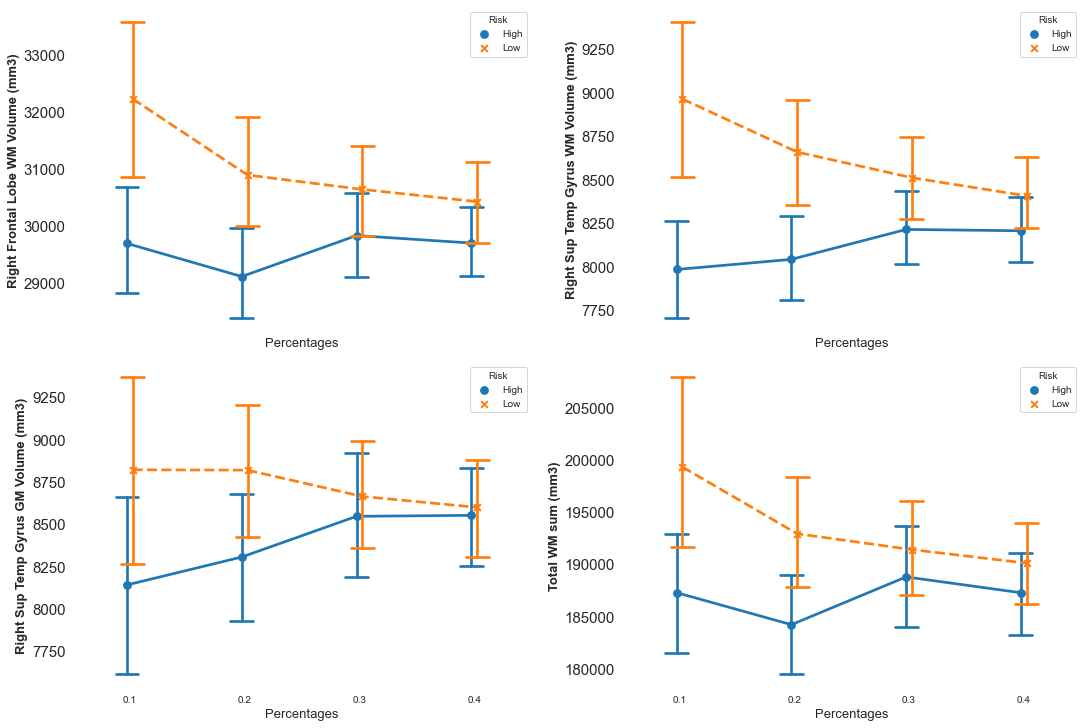

In [144]:
fig,axes = plt.subplots(2,2,figsize=(15,10),constrained_layout=True,sharex=True)
# axes[1,1].remove()
axes = axes.flatten()
for ax, variable,var_name in zip(axes,dependentVar,['Right Frontal Lobe WM Volume (mm3)',
                                                   'Right Sup Temp Gyrus WM Volume (mm3)',
                                                   'Right Sup Temp Gyrus GM Volume (mm3)',
                                                   'Total WM sum (mm3)']):
    sns.pointplot(x='Percentages',
                  y=variable,
                  data=risk_df,
                  hue='Risk',
                  dodge=True,
                 markers=['o','x'],
                 linestyles=['-','--'],capsize=.2,ax=ax)
    sns.despine(top=True,bottom=True,right=True,left=True)
    ax.set_ylabel(var_name,fontdict={'fontsize':13,'fontweight':'bold'})
    ax.set_xlabel('Percentages',fontdict={'fontsize':13})
    ax.tick_params(axis='y', labelsize=15)
# plt.savefig(f'{preprocessed_dataset_path}/output_plot/high_low_risk_european.svg')

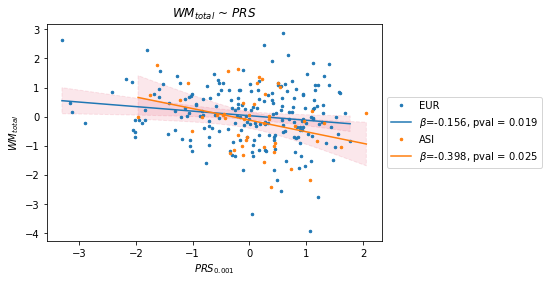

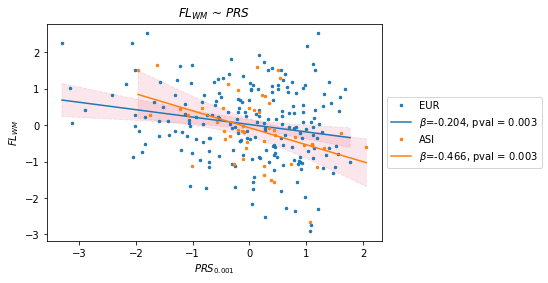

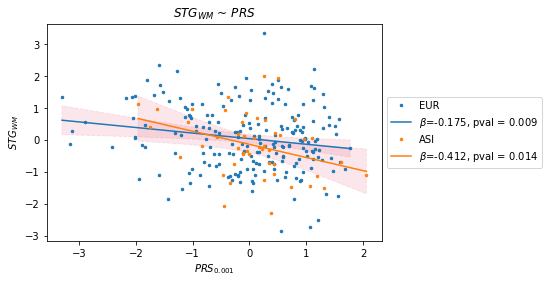

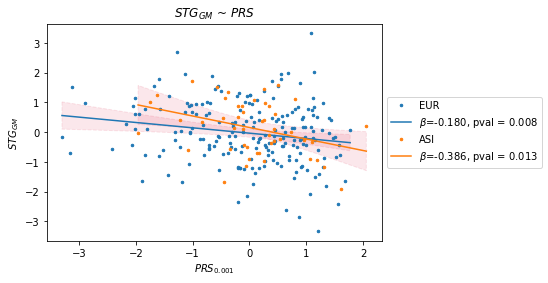

In [11]:
dependent_var = [
    'WM_sum_Imperial', 'Imperial 79', 'Imperial 58', 'Imperial 12'
]
ylbl = ['$WM_{total}$', '$FL_{WM}$', '$STG_{WM}$', '$STG_{GM}$']
ancestry = ['mixed_Anc_PC' + str(i) for i in range(1, 6)]
df = mixed_volumetric_dataset_term

for var, ylabel in (zip(dependent_var, ylbl)):
    model, _ = data_exploration.MassUnivariate.mass_univariate(
        df=df,
        cat_independentVar_cols=['Gender'],
        cont_independentVar_cols=[
            'GA_vol', 'PMA_vol', 'Intracranial_Imperial'
        ],
        dependentVar_cols=[var])
    model2, _ = data_exploration.MassUnivariate.mass_univariate(
        df=df,
        cont_independentVar_cols=ancestry,
        dependentVar_cols=['PRS_0.001'])
#     plt.style.use('seaborn-whitegrid')
    visualisation.plot_Linear_Reg(
        model2.resid.values,
        model.resid.values,
        data=mixed_volumetric_dataset_term,
        ylabel=ylabel,
        xlabel='$PRS_{0.001}$',
        hue='cohort',
        title='%s ~ $PRS$' % ylabel,
        combined=False,
    markersize=5)

## Other tests

### check if removing or adding variables changes the R2

In [13]:
all_models = data_exploration.MassUnivariate.check_all_predictors_combo_linear_Reg(df = mixed_volumetric_dataset_term,
                                           cat_independentVar_cols=['Gender'],
                                           cont_independentVar_cols=['PRS_0.001','mixed_Anc_PC1','mixed_Anc_PC2','mixed_Anc_PC3',
                                                                     'mixed_Anc_PC4','mixed_Anc_PC5',
                                                                    'GA_vol','PMA_vol','Intracranial_Imperial'],
                                          dependentVar_cols=['WM_sum_Imperial'])

100%|███████████████████████████████████████████| 10/10 [00:10<00:00,  1.06s/it]


In [15]:
model_score_summary, model_var_summary, model_beta_summary, model_p_summary = data_exploration.MassUnivariate.preprocess_forward_selection(all_models)

The best model is when including all the covariates, but with less it still achieves similar results

In [22]:
model_score_summary.sort_values(by='R2',ascending=False)

,N_var,AIC,R2,R2_adj
1023,10,215.648386,8.756160e-01,8.705597e-01
1018,9,213.648958,8.756157e-01,8.710835e-01
1020,9,213.742773,8.755703e-01,8.710364e-01
994,8,211.747326,8.755681e-01,8.715541e-01
1019,9,213.916692,8.754860e-01,8.709491e-01
...,...,...,...,...
7,1,731.878817,5.647762e-03,1.748342e-03
47,2,735.165348,6.575971e-04,-7.211241e-03
8,1,733.195754,5.393560e-04,-3.380098e-03
6,1,733.309411,9.725271e-05,-3.823935e-03


<AxesSubplot:xlabel='N_var'>

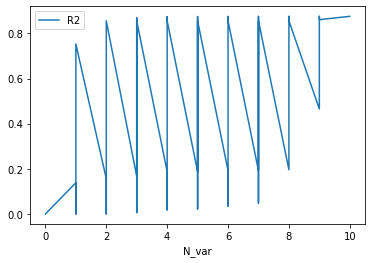

In [24]:
model_score_summary.plot('N_var','R2')

### adding preterm

In [29]:
european_volumetric_preterm_term_mass_univariate = pd.read_csv(
    './preprocessed_dataset/imaging_data/volumetric/preterm_term/european_volumetric_preterm_term_mass_univariate.csv'
)

In [32]:
data_preprocessing.Volumes.extract_WM_Imperial(european_volumetric_preterm_term_mass_univariate).sort_values(by='PRS_pval')

,Connection,const_coef,const_pval,GA_vol_coef,GA_vol_pval,PMA_vol_coef,PMA_vol_pval,euro_Anc_PC1_coef,euro_Anc_PC1_pval,euro_Anc_PC2_coef,euro_Anc_PC2_pval,euro_Anc_PC3_coef,euro_Anc_PC3_pval,Intracranial_Imperial_coef,Intracranial_Imperial_pval,PRS_coef,PRS_pval,Gender_2.0_coef,Gender_2.0_pval,threshold
630,Imperial 79,0.089234,0.009166,0.222168,1.095722e-10,-0.598642,1.375070e-21,-0.036649,0.158641,-0.028282,0.262465,0.019237,0.433409,1.248126,4.956868e-67,-0.070116,0.005742,-0.197588,0.000222,PRS_0.1
558,Imperial 79,0.088570,0.009781,0.221963,1.188279e-10,-0.599497,1.328617e-21,-0.034744,0.180228,-0.028948,0.252092,0.019136,0.436547,1.249594,4.398070e-67,-0.067245,0.007844,-0.196119,0.000251,PRS_0.05
414,Imperial 79,0.086724,0.011485,0.222626,1.086336e-10,-0.605411,5.751416e-22,-0.031050,0.227522,-0.027863,0.270361,0.014314,0.558126,1.255667,1.133521e-67,-0.064906,0.009110,-0.192031,0.000343,PRS_0.001
270,Imperial 79,0.086523,0.011685,0.222842,1.049350e-10,-0.608548,3.778565e-22,-0.027886,0.275968,-0.026680,0.291166,0.011953,0.624339,1.259979,4.896486e-68,-0.064263,0.009188,-0.191586,0.000354,PRS_1e-05
280,WM_sum_Imperial,0.094424,0.000977,0.186887,7.194661e-11,-0.494796,1.970774e-21,-0.020011,0.346474,-0.022522,0.283408,0.005777,0.775667,1.222138,4.033948e-80,-0.052604,0.010241,-0.209081,0.000003,PRS_1e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,Imperial 55,-0.014055,0.814985,0.294812,7.870784e-07,-0.267992,8.047819e-03,0.062955,0.168771,0.029200,0.512209,0.001909,0.964887,0.784182,5.136692e-16,-0.001004,0.981913,0.031123,0.738435,PRS_0.05
339,Imperial 66,0.102358,0.041317,0.060628,2.105757e-01,-0.551098,2.278240e-10,0.000105,0.997776,-0.027987,0.449537,-0.024654,0.490684,1.202985,3.573970e-40,0.000623,0.986190,-0.226651,0.003773,PRS_0.0001
254,Imperial 51,0.075592,0.178395,0.035679,5.111853e-01,0.075170,4.215992e-01,-0.000051,0.999042,-0.022600,0.586387,-0.015904,0.691993,0.693568,7.734637e-15,0.000643,0.987273,-0.167383,0.055429,PRS_1e-05
38,Imperial 51,0.075549,0.178456,0.035702,5.108313e-01,0.075171,4.215911e-01,-0.000130,0.997530,-0.022595,0.586482,-0.015888,0.692314,0.693525,7.580347e-15,-0.000250,0.995037,-0.167286,0.055354,PRS_1e-08
